# Tim Hortons Simulation Code

Note: This does not need to be an ipynb file, but I figure this might be simplest. 

In [598]:
############
# PACKAGES #
############

import numpy as np
import heapq # Event tree package
from scipy.stats import truncnorm


In [599]:
######################
# TUNABLE PARAMETERS #
######################

# FRONTEND PARAMETERS
NUM_CASHIERS = 2

# KITCHEN PARAMETERS
NUM_COOKS = 5
NUM_BARISTAS = 5

NUM_PANINI = 2
NUM_SANDWICH = 2
NUM_HASHBROWN_STATIONS = 1

NUM_ESPRESSO_MAKER = 2
NUM_DONUT_STATIONS = 1




####################
# FIXED PARAMETERS #
####################
# TODO - TODO - TODO - TODO - TODO - TODO #
# Set all of these to reasonable values   #
# TODO - TODO - TODO - TODO - TODO - TODO #

# FRONTEND PARAMETERS
# TODO - Make these variable throughout the day

# DO NOT USE THIS!!! THIS IS A HELPER FUNCTION
def ARRIVAL_RATE_FUNC(x, mult):
    x = x / 60 # Time is measured in minutes, convert it to hours

    if 0 <= x <= 2:
        return mult*(x+0.5)/2.5
    elif 2 < x <= 3:
        return mult*1
    elif 3 < x <= 4:
        return -mult*(x-5)/2
    elif 4 < x <= 5:
        return mult*0.5
    elif 5 < x <= 6:
        return mult*1.5*(x - 14/3)
    elif 6 < x <= 7:
        return mult*2
    elif 7 < x <= 10:
        return -mult*(x-11)/2
    elif 10 < x <= 12:
        return mult*(x-17/2)/3
    elif 12 < x <= 14:
        return -mult*(x-43/3)/2
    else:
        raise ValueError("Invalid Time!!")
        
# USE INTERARRIVAL FUNC!!! THIS IS WHAT WE USE IN EXPON FUNCTION
def INTERARRIVAL_FUNC(x, mult):
    return 1 / ARRIVAL_RATE_FUNC(x, 1/mult)

MEAN_DRIVE_THRU_INTERARRIVAL = 40
MEAN_WALK_IN_INTERARRIVAL = 20
MEAN_MOBILE_INTERARRIVAL = 10
MEAN_MOBILE_FINISH_TIME = 15

MEAN_WINDOW1_SERVICE = 0.5
MEAN_WINDOW2_SERVICE = 0.5
MEAN_CASHIER_SERVICE = 1

# FOOD PARAMETERS
MEAN_PANINI_TIME = 2
MEAN_HASHBROWN_TIME = 0.2
MEAN_SANDWICH_TIME = 1

MEAN_COFFEE_TIME = 0.5
MEAN_ESPRESSO_TIME = 1
MEAN_DONUT_TIME = 0.2

COFFEE_URN_CAPACITY = 30 # Number of coffees that fit into an urn
ESPRESSO_MAKER_CAPACITY = 20 # Number of espressos that can be made before a cleaning cycle is required

MEAN_ESPRESSO_CLEANING_TIME = 5
MEAN_BARISTA_BREW_TIME = 2
MEAN_COFFEE_URN_BREWING_TIME = 5

# BACKEND PARAMETERS
MEAN_ASSEMBLY_TIME = 0.05
MEAN_HAND_OFF_DRIVE_THRU_TIME = 0.1
MEAN_HAND_OFF_WALK_IN_OR_MOBILE_TIME = 0.05
MEAN_PICKUP_TIME = 1
PICKUP_SHELF_SLOTS = 10

WALK_IN_DINE_IN_CHANCE = 0.7
MOBILE_DINE_IN_CHANCE = 0.2

NUM_LARGE_TABLES = 8
NUM_MED_TABLES = 6
NUM_SMALL_TABLES = 6
MEAN_SEATING_TIME = 10

MEAN_SMALL_BUSSING_TIME = 0.75
MEAN_MED_BUSSING_TIME = 1
MEAN_LARGE_BUSSING_TIME = 1.5

# MONEY
PANINI_PRICE = 7.29
HASHBROWN_PRICE = 2.19
SANDWICH_PRICE = 4.99

COFFEE_PRICE = 1.92
ESPRESSO_PRICE = 1.79
DONUT_PRICE = 1.69

PANINI_INGREDIENT_COST = 3
HASHBROWN_INGREDIENT_COST = 0.5
SANDWICH_INGREDIENT_COST = 2

COFFEE_INGREDIENT_COST = 0.5
ESPRESSO_INGREDIENT_COST = 0.5
DONUT_INGREDIENT_COST = 0.75

MINIMUM_WAGE = 17.85

In [600]:
###########
# CLASSES #
###########

# NOTE - We can change classes as needed

class Order:
    # Intialize an order object
    def __init__(self, type, num_customers, num_items, creation_time, expected_time):
        self.num_customers = num_customers # Number of customers for seating, irrelevant to drive-thru
        self.num_items = num_items         # Number of customers for checking condition of order completion
        self.items_completed = 0           # Number of items completed, must equal num_items to complete order
        self.creation_time = creation_time # Time the order is first instantiated (once order enters customer service queue)
        self.expected_time = expected_time # (Only relevant to mobile orders)
        self.cash_value = 0                # The total amount the order is worth, add money when items are created
        self.profit = 0                    # The total amount profited from the order, add money when items are created

        # Walk-in, pick-up, or drive-thru
        if (type.lower() == "walk-in") or (type.lower() == "drive-thru") or (type.lower() == "mobile"):
            self.order_type = type.lower()
        else:
            # Prevent bugs
            raise NameError("Invalid order type string ", type.lower())


class Food:
    # Initialize food object, each order has many corresponding food items
    def __init__(self, food_id, order, type, creation_time, expected_time):
        self.food_id = food_id             # Id for food item
        self.order = order                 # Corresponding order
        self.food_type = type              # Type of food item (i.e. coffee, sandwich, etc.)
        self.creation_time = creation_time # Time the item is first instantiated (once order enters customer service queue)
        self.expected_time = expected_time # (Only relevant to mobile orders)

        # Type of food item (coffee, espresso, donut, panini, hashbrown, sandwich, etc.)
        if (type.lower() == "coffee") or (type.lower() == "espresso") or (type.lower() == "donut") or (type.lower() == "panini") or (type.lower() == "hashbrown") or (type.lower() == "sandwich"):
            self.food_type = type.lower()
        else:
            # Prevent bugs
            raise NameError("Invalid food type string ", type.lower())

        if type.lower() == "coffee":
            self.mean_service_time = MEAN_COFFEE_TIME
            self.cash_value = COFFEE_PRICE
            self.profit = COFFEE_PRICE - COFFEE_INGREDIENT_COST

        elif type.lower() == "espresso":
            self.mean_service_time = MEAN_ESPRESSO_TIME
            self.cash_value = ESPRESSO_PRICE
            self.profit = ESPRESSO_PRICE - ESPRESSO_INGREDIENT_COST
            
        elif type.lower() == "donut":
            self.mean_service_time = MEAN_DONUT_TIME
            self.cash_value = DONUT_PRICE
            self.profit = DONUT_PRICE - DONUT_INGREDIENT_COST

        elif type.lower() == "panini":
            self.mean_service_time = MEAN_PANINI_TIME
            self.cash_value = PANINI_PRICE
            self.profit = PANINI_PRICE - PANINI_INGREDIENT_COST

        elif type.lower() == "sandwich":
            self.mean_service_time = MEAN_SANDWICH_TIME
            self.cash_value = SANDWICH_PRICE
            self.profit = SANDWICH_PRICE - SANDWICH_INGREDIENT_COST
            
        elif type.lower() == "hashbrown":
            self.mean_service_time = MEAN_HASHBROWN_TIME
            self.cash_value = HASHBROWN_PRICE
            self.profit = HASHBROWN_PRICE - HASHBROWN_INGREDIENT_COST
    

class Staff:
    # Create a staff worker
    def __init__(self, type):
        self.staff_idle = True   # Bool for if the staff is working or not

        # Worker type (i.e. barista, cashier, kitchen, drive-thru window, etc.)
        if (type.lower() == "kitchen") or (type.lower() == "cafe") or (type.lower() == "cashier") or (type.lower() == "drive-thru") or  (type.lower() == "assembler") or (type.lower() == "busser"):
            self.staff_type = type.lower()
        else:
            # Prevent bugs
            raise NameError("Invalid food type string ", type.lower())
    
    

class Equipment:
    # Create a piece of equipment
    def __init__(self, type, num_slots, capacity):
        self.eq_type = type        # The equipment type
        self.num_slots = num_slots # The total number of people who can work at a station/equipment
        self.used_slots = 0        # The number of equipment slots currently in use

        # Use capacity for coffee urn and espresso cleaning cycle
        self.remaining_amount = capacity
        self.blocked = False

        # Equipment type (i.e. panini-press, sandwich-station, espresso-maker, coffee-urn, etc.)
        if (type.lower() == "panini-press") or (type.lower() == "sandwich-station") or (type.lower() == "espresso-maker") or (type.lower() == "coffee-urn") or (type.lower() == "cash-register") or (type.lower() == "hashbrown-station") or (type.lower() == "donut-station"):
            self.eq_type = type.lower()
        else:
            # Prevent bugs
            raise NameError("Invalid food type string ", type.lower())



class Event:
    def __init__(self, time, event_function, obj):
        self.time = time               # Time that the event must occur
        self.func = event_function     # Function which triggers upon event
        self.obj = obj                 # Object assocaited with event (i.e. Food, Order, etc.)

    # Less than function used for heapq
    # The choice is arbitrary to us, so just return True
    def __lt__(self, other):
        return True

In [601]:
###########################
# EVENT TREE INSTRUCTIONS #
###########################
##
# NOTE - The heapq package handles all the logic, and sorts by minimul value
##

# To add an event object to the event tree in O(log(n)), do the following:
"""  
time = some_event_time
event_data = Event(some_stuff)
heapq.heappush(event_tree, (time, event_id, event_data))
"""

# Then to pop the event off of the event tree in O(log(n)), do the following:
"""
time, event = heapq.heappop(event_queue)
"""

# Or to peek at the next event in O(1), do the following:
"""
time, event = event_queue[0]
"""


'\ntime, event = event_queue[0]\n'

In [602]:
class TimHortons:

    ##################
    ##################
    #                #
    # INITIALIZAITON #
    #                #
    ##################
    ##################
    
    def __init__(self, end_time):
        
        ############
        # FRONTEND #
        ############
        self.cashiers = [Staff("cashier") for i in range(NUM_CASHIERS)]
        self.drive_thru_window = Staff("drive-thru")

        # current not being used, but can easily implement balking
        self.drive_thru_window1_length = 10
        self.drive_thru_window2_length = 3
        self.drive_thru_freeze = False

        self.next_food_id = 0 # indexing starts at 0
        
        self.drive_thru_window1_queue = []
        self.drive_thru_window2_queue = []
        self.walk_in_queue = []



        ###########
        # KITCHEN #
        ###########
        # Staff
        self.cooks = [Staff("kitchen") for i in range(NUM_COOKS)]
        self.baristas = [Staff("cafe") for i in range(NUM_BARISTAS)]

        # Equipment
        self.panini_press = Equipment("panini-press", NUM_PANINI, -1)
        self.sandwich_station = Equipment("sandwich-station", NUM_SANDWICH, -1)
        self.hashbrown_station = Equipment("hashbrown-station", NUM_HASHBROWN_STATIONS, -1)
        self.espresso_maker = Equipment("espresso-maker", NUM_ESPRESSO_MAKER, ESPRESSO_MAKER_CAPACITY)
        self.coffee_urn1 = Equipment("coffee-urn", 1, COFFEE_URN_CAPACITY)
        self.coffee_urn2 = Equipment("coffee-urn", 1, COFFEE_URN_CAPACITY)
        self.donut_station = Equipment("donut-station", NUM_DONUT_STATIONS, -1)

        self.current_coffee_urn = 1

        # Queues
        self.event_queue = []
        self.kitchen_queue = []
        self.cafe_queue = []

        # Ids
        self.next_food_id = 0



        ###########
        # BACKEND #
        ###########
        # Staff
        # TODO - Do we want to have multiple assemblers?
        self.assembler = Staff("assembler")
        self.busser = Staff("busser")

        # Queues
        self.assembler_queue = []
        self.busser_queue = []

        # Finite-capacity pickup shelf
        self.pickup_self_slots = PICKUP_SHELF_SLOTS
        self.occupied_pickup_shelf_slots = 0

        # Seating
        self.num_large_tables = NUM_LARGE_TABLES # Fit 4 people each
        self.num_med_tables = NUM_MED_TABLES     # Fit 2 people each
        self.num_small_tables = NUM_SMALL_TABLES # Fit 1 person each
        self.occupied_large_tables = 0
        self.occupied_med_tables = 0
        self.occupied_small_tables = 0

        ##########
        # SHARED #
        ##########
        # State variables
        self.sim_time = 0
        self.time_last_event = 0.0
        self.end_time = end_time
        self.num_orders_filled = 0

        # Stats
        self.total_time_in_kitchen = 0
        self.area_in_kitchen_queue = 0
        self.area_in_cafe_queue = 0
        self.total_income = 0
        self.total_food_profit = 0
        self.total_worker_wages = 0
        self.total_num_staff = NUM_CASHIERS + 1 + NUM_COOKS + NUM_BARISTAS + 1 + 1 # TODO - This may need to be modified
        self.dissatisfaction_score = 0

        ##################
        # INITIAL EVENTS #
        ##################
        # Drive-thru event
        initial_drive_thru_arrival = self.sim_time+self.expon(INTERARRIVAL_FUNC(self.sim_time, MEAN_DRIVE_THRU_INTERARRIVAL))
        heapq.heappush(self.event_queue, (initial_drive_thru_arrival, Event(initial_drive_thru_arrival, self.arrival, "drive-thru")))
        
        # Walk-in event
        initial_walk_in_arrival = self.sim_time+self.expon(INTERARRIVAL_FUNC(self.sim_time, MEAN_WALK_IN_INTERARRIVAL))
        heapq.heappush(self.event_queue, (initial_walk_in_arrival, Event(initial_walk_in_arrival, self.arrival, "walk-in")))

        # Mobile event
        initial_mobile_arrival = self.sim_time+self.expon(INTERARRIVAL_FUNC(self.sim_time, MEAN_MOBILE_INTERARRIVAL))
        heapq.heappush(self.event_queue, (initial_mobile_arrival, Event(initial_mobile_arrival, self.arrival, "mobile")))









    ####################
    ####################
    #                  #
    # HELPER FUNCTIONS #
    #                  #
    ####################
    ####################

    def expon(self, mean):
        """Function to generate exponential random variates."""
        return -mean * np.log(np.random.uniform(0, 1))

    def trunc_norm(self, mean):
        std = mean*0.25 # standard deviation is 25% of the mean
        trun_norm_func = truncnorm(-3, 3, loc=mean, scale=std)
        return trun_norm_func.rvs()

    
    # priority for food and beverage items
    def food_priority(self, food):
        return -food.creation_time


    def remove_from_queue(self, food, queue):
        for i in range(len(queue)):
            if food.food_id == queue[i].food_id:
                del queue[i]
                return

        print("Error: food not found in queue")


    # returns food in given array that have available equipment
    def get_possible_food(self, food_array):
        possible_food = []
        for food in food_array:
            if self.is_equipment_available(self.get_equipment(food)):
                possible_food.append(food)

        return possible_food


    def is_equipment_available(self, equip):
        return equip.num_slots > equip.used_slots
    

    def get_equipment(self, food):
        type = food.food_type

        if type == "panini":
            return self.panini_press
        elif type == "sandwich":
            return self.sandwich_station
        elif type == "hashbrown":
            return self.hashbrown_station
        elif type == "coffee":
            if self.current_coffee_urn == 1:
                return self.coffee_urn1
            elif self.current_coffee_urn == 2:
                return self.coffee_urn2
            else:
                raise NameError("Invalid coffee urn number")
        elif type == "espresso":
            return self.espresso_maker
        elif type == "donut":
            return self.donut_station
        else:
            raise NameError("Invalid equipment type")
        
        
    def is_kitchen_item(self, food):
        type = food.food_type
        if (type == "panini") or (type == "sandwich") or (type == "hashbrown"):
            return True
        else:
            return False
    

    def is_cafe_item(self, food):
        type = food.food_type
        if (type == "coffee") or (type == "espresso") or (type == "donut"):
            return True
        else:
            return False
        

    def is_queue_empty(self, food):
        return (self.is_kitchen_item(food) and len(self.kitchen_queue) == 0) \
            or (self.is_cafe_item(food) and len(self.cafe_queue) == 0)








    ###################
    ###################
    #                 #
    # FRONTEND EVENTS #
    #                 #
    ###################
    ###################

    def generate_order(self, order_type):
        # TODO - Should we use correlation matrices?
        num_customers = np.random.randint(1,5) # Generate random number in 1 to 4 (does not include 5)
        num_drinks = np.random.randint(1, 2*num_customers+1)
        num_food = np.random.randint(1, 2*num_customers+1)

        drink = np.random.choice(["coffee", "espresso", "donut"], size=num_drinks) # uniform by default, but probabilities can be assigned
        food = np.random.choice(["panini", "sandwich", "hashbrown"], size=num_food) # uniform by default, but probabilities can be assigned
    
        if order_type == "mobile":
            expected_time = self.sim_time + self.trunc_norm(MEAN_MOBILE_FINISH_TIME) # current time + 20 minutes, TODO - CHANGE THIS TO BE A RANDOM NUMBER
        else:
            expected_time = np.inf
            
        # CREATING ORDER OBJECT
        order = Order(order_type, num_customers, len(drink)+len(food), self.sim_time, expected_time)

        # CREATING FOOD OBJECT FOR ALL FOOD ITEMS TO BE GIVEN TO KITCHEN
        for item in np.concatenate((drink, food)):
            food = Food(self.next_food_id, order, item, self.sim_time, expected_time)
            food_event = Event(self.sim_time, self.handle_kitchen_arrival, food)
            heapq.heappush(self.event_queue, (self.sim_time, food_event))

            order.cash_value += food.cash_value
            order.profit += food.profit


            self.next_food_id += 1 # updating the food index

        return order
        
    
    def place_order(self, order_location):
        order_type, server_pos = order_location
        order = self.generate_order(order_type) # generate an order event because we have been serviced

        if order_type == "walk-in":
            # CHECKING IF ANYONE IS IN THE QUEUE
            if len(self.walk_in_queue) > 0:
                order_time = self.sim_time+self.expon(MEAN_CASHIER_SERVICE)
                order_event = Event(order_time, self.place_order, (order_type, server_pos))
                heapq.heappush(self.event_queue, (order_time, order_event))
                del self.walk_in_queue[0]

            else:
                self.cashiers[server_pos].staff_idle = True
                
        elif order_type == "drive-thru":
            # SCHEDULING THE ARRIVAL AT PICKUP
            self.drive_thru_window2_queue.append(order)
            if len(self.drive_thru_window2_queue) >= self.drive_thru_window2_length:
                self.drive_thru_freeze = True


            # CHECKING IF ANYONE IS IN THE QUEUE AND IF THE QUEUE CAN MOVE
            if (len(self.drive_thru_window1_queue) > 0) and (not self.drive_thru_freeze):
                order_time = self.sim_time+self.expon(MEAN_WINDOW1_SERVICE)
                order_event = Event(order_time, self.place_order, (order_type, server_pos))
                heapq.heappush(self.event_queue, (order_time, order_event))
                del self.drive_thru_window1_queue[0]

            else:
                self.drive_thru_window.staff_idle = True


    def arrival(self, arrival_type):
        if arrival_type.lower() == "walk-in":
            # SCHEDULE NEXT ARRIVAL
            walk_in_arrival_time = self.sim_time+self.expon(INTERARRIVAL_FUNC(self.sim_time, MEAN_WALK_IN_INTERARRIVAL))
            heapq.heappush(self.event_queue, (walk_in_arrival_time, Event(walk_in_arrival_time, self.arrival, "walk-in")))

            # CHECKING IF CASHIERS ARE BUSY
            first_free_cashier = -1
            i = 0
            for cashier in self.cashiers:
                if cashier.staff_idle:
                    first_free_cashier = i
                i += 1
                
            if first_free_cashier < 0:
                self.walk_in_queue.append(self.sim_time) # all cashiers are busy, so add customer to queue
            else:
                self.cashiers[first_free_cashier].staff_idle = False
                # CREATING A PLACE ORDER EVENT
                order_time = self.sim_time+self.expon(MEAN_CASHIER_SERVICE)
                order_event = Event(order_time, self.place_order, (arrival_type, first_free_cashier))
                heapq.heappush(self.event_queue, (order_time, order_event))
                
        elif arrival_type.lower() == "drive-thru":
            # SCHEDULE NEXT ARRIVAL 
            drive_thru_arrival_time = self.sim_time+self.expon(INTERARRIVAL_FUNC(self.sim_time, MEAN_DRIVE_THRU_INTERARRIVAL))
            heapq.heappush(self.event_queue, (drive_thru_arrival_time, Event(drive_thru_arrival_time, self.arrival, "drive-thru")))

            if len(self.drive_thru_window1_queue) >= self.drive_thru_window1_length:
                # The drive-thru is full, skip placing order
                self.dissatisfaction_score += 10
                return

            # CHECKING IF DRIVE-THRU WINDOW 1 IS BUSY
            if self.drive_thru_window.staff_idle:
                if self.drive_thru_freeze:
                    # This person cannot be processed as the drive thru is frozen (window 2 line is filled)
                    self.drive_thru_window1_queue.append(self.sim_time) # add to queue if busy   
                else:
                    self.drive_thru_window.staff_idle = False # make window 1 server busy
                    # CREATING A PLACE ORDER EVENT 
                    order_time = self.sim_time+self.expon(MEAN_WINDOW1_SERVICE)
                    order_event = Event(order_time, self.place_order, (arrival_type, 0)) # server position is 0 because there is only one server
                    heapq.heappush(self.event_queue, (order_time, order_event))
            else:
                self.drive_thru_window1_queue.append(self.sim_time) # add to queue if busy
                
        elif arrival_type.lower() == "mobile":
            # SCHEDULE NEXT ARRIVAL
            mobile_arrival_time = self.sim_time+self.expon(INTERARRIVAL_FUNC(self.sim_time, MEAN_MOBILE_INTERARRIVAL))
            heapq.heappush(self.event_queue, (mobile_arrival_time, Event(mobile_arrival_time, self.arrival, "mobile")))
            
            # CREATING A PLACE ORDER EVENT
            order_event = Event(self.sim_time, self.place_order, (arrival_type,0)) # assuming there is no service time for mobile order
            heapq.heappush(self.event_queue, (self.sim_time, order_event))
            
        else:
            raise NameError("Invalid order type string ", arrival_type.lower())









##################
##################
#                #
# KITCHEN EVENTS #
#                #
##################
##################

    def handle_kitchen_arrival(self, food):
        # If corresponding equipment is unavailable
        equip = self.get_equipment(food)
        if not self.is_equipment_available(equip):
            # Put onto correct queue
            if self.is_kitchen_item(food):
                self.kitchen_queue.append(food)
            else:
                self.cafe_queue.append(food)
            return

        # Select worker set
        if self.is_kitchen_item(food):
            workers = self.cooks
        else:
            workers = self.baristas

        # If any workers are idle
        for worker in workers:
            if worker.staff_idle:
                # assign cook and equipment slot
                worker.staff_idle = False
                equip.used_slots += 1

                # schedule departure
                time = self.sim_time + self.trunc_norm(food.mean_service_time)
                obj = (food, worker)
                event = Event(time, self.handle_kitchen_departure, obj)
                heapq.heappush(self.event_queue, (time, event))

                return
        
        # If equipment is available but no cooks, join queue
        if self.is_kitchen_item(food):
            self.kitchen_queue.append(food)
        else:
            self.cafe_queue.append(food)
        return



    def handle_kitchen_departure(self, obj):
        food, worker = obj

        # The item is done, hand it to the assembler immediately
        # The assembly function will handle and necessary events
        self.handle_food_assembly_arrival(food)

        equip = self.get_equipment(food)
        equip.used_slots -= 1

        # For coffees, update the number of coffees remaining in the urn
        if food.food_type == "coffee":
            if self.current_coffee_urn == 1:
                self.coffee_urn1.remaining_amount -= 1
                if self.coffee_urn1.remaining_amount == 0:
                    # If the coffee urn is empty, switch to the other one and start brewing a new batch
                    self.current_coffee_urn = 2
                    self.coffee_urn1.used_slots = self.coffee_urn1.num_slots # Block coffee maker

                    # The barista who just emptied the urn fills it immediately, since it blocks other items in queue
                    time = self.sim_time + self.trunc_norm(MEAN_BARISTA_BREW_TIME)
                    obj = (self.coffee_urn1, worker)
                    refill_event = Event(time, self.refill_coffee_urn_event, obj)
                    heapq.heappush(self.event_queue, (time, refill_event))

                    return # Do not continue to find a new job for this barista as they have just been given a job

            elif self.current_coffee_urn == 2:
                self.coffee_urn2.remaining_amount -= 1

                if self.coffee_urn2.remaining_amount == 0:
                    # If the coffee urn is empty, switch to the other one and start brewing a new batch
                    self.current_coffee_urn = 1
                    self.coffee_urn2.used_slots = self.coffee_urn2.num_slots # Block coffee maker

                    # The barista who just emptied the urn fills it immediately, since it blocks other items in queue
                    # TODO - Make truncated gaussian rather than exponential
                    time = self.sim_time + self.trunc_norm(MEAN_BARISTA_BREW_TIME)
                    obj = (self.coffee_urn2, worker)
                    refill_event = Event(time, self.refill_coffee_urn_event, obj)
                    heapq.heappush(self.event_queue, (time, refill_event))

                    return # Do not continue to find a new job for this barista as they have just been given a job

            else:
                raise NameError("Invalid coffee urn number")
            

        if food.food_type == "espresso":
            self.espresso_maker.remaining_amount -= 1
            if self.espresso_maker.remaining_amount == 0:
                # Put 1 espresso maker out of service temporarily
                self.espresso_maker.used_slots += 1

                # Have the barista immediately start cleaning the espresso maker
                time = self.sim_time + self.expon(MEAN_ESPRESSO_CLEANING_TIME)
                cleaning_event = Event(time, self.espresso_cleaning_event, worker)
                heapq.heappush(self.event_queue, (time, cleaning_event))

                return # Do not continue to find a new job for this barista as they have just been given a job


        # Get the next job for worker and run it, if any exist
        self.find_next_job(worker, food)


    def find_next_job(self, worker, food):
        # No food in queue
        if self.is_queue_empty(food):
            worker.staff_idle = True
        else:
            # get next food that has an available equipment
            if self.is_kitchen_item(food):
                possible_food = self.get_possible_food(self.kitchen_queue)
            else:
                possible_food = self.get_possible_food(self.cafe_queue)

            if possible_food == []:
                worker.staff_idle = True
                return

            # Get food item with max priority
            # TODO - Implement advanced priority system
            next_food = max(possible_food, key=self.food_priority)
            
            # remove food from kitchen_queue
            if self.is_kitchen_item(next_food):
                self.remove_from_queue(next_food, self.kitchen_queue)
            else:
                self.remove_from_queue(next_food, self.cafe_queue)

            # worker stays busy
            next_equip = self.get_equipment(next_food)
            next_equip.used_slots += 1

            # schedule departure
            next_time = self.sim_time + self.trunc_norm(next_food.mean_service_time)
            obj = (next_food, worker)
            event = Event(next_time, self.handle_kitchen_departure, obj)
            heapq.heappush(self.event_queue, (next_time, event))



    # The barista sets up brewing, then it is ready after some time
    def refill_coffee_urn_event(self, obj):
        urn, barista = obj

        # The barista has finished their part, let them get back to work while the coffe brews
        dummy_food = Food(-1, -1, "coffee", -1, -1) # Fabricated food object (code HACK)
        self.find_next_job(barista, dummy_food)

        # Schedule a new event for when the coffee is ready
        # TODO - Make truncated gaussian rather than exponential
        brewing_time = self.sim_time + self.trunc_norm(MEAN_COFFEE_URN_BREWING_TIME)
        finished_brewing_event = Event(brewing_time, self.coffee_complete_event, urn)
        heapq.heappush(self.event_queue, (brewing_time, finished_brewing_event))


    # Nobody handles this event, it just happens after some time
    # Unblock coffee urn so that it can be used again
    def coffee_complete_event(self, urn):
        urn.remaining_amount = COFFEE_URN_CAPACITY
        urn.used_slots = 0 # Unblock coffee urn


    def espresso_cleaning_event(self, barista):
        # The barista has finished cleaning, let them get back to work
        dummy_food = Food(-1, -1, "espresso", -1, -1) # Fabricated food object (code HACK)
        self.find_next_job(barista, dummy_food)

        # Put the espresso maker back into service
        self.espresso_maker.remaining_amount = ESPRESSO_MAKER_CAPACITY
        self.espresso_maker.used_slots -= 1
        





        
    ##################
    ##################
    #                #
    # BACKEND EVENTS #
    #                #
    ##################
    ##################

    def handle_food_assembly_arrival(self, food):
        if self.assembler.staff_idle:
            # An assembler is available, so package the food
            assembly_time = self.sim_time + self.expon(MEAN_ASSEMBLY_TIME)
            assembly_event = Event(assembly_time, self.handle_food_assembly, food)
            heapq.heappush(self.event_queue, (assembly_time, assembly_event))

            # The assembler becomes busy
            self.assembler.staff_idle = False
        else:
            # The assembler is busy, throw the food assembly onto the queue
            self.assembler_queue.append(food)


    def handle_food_assembly(self, food):
        food.order.items_completed += 1

        if food.order.items_completed == food.order.num_items:

            # There is no queue for this. Once an order is done, hand it off immediately.
            # Drive-thru orders take longer to hand off than walk-ins and mobile.
            handoff_time = self.sim_time
            if food.order.order_type == "drive-thru":
                handoff_time += self.expon(MEAN_HAND_OFF_DRIVE_THRU_TIME) 
            else:
                handoff_time += self.expon(MEAN_HAND_OFF_WALK_IN_OR_MOBILE_TIME)

            # No queue, just handoff immediately taking priority over any other job
            handoff_event = Event(handoff_time, self.handle_food_handoff, food.order)
            heapq.heappush(self.event_queue, (handoff_time, handoff_event))
        else:
            if len(self.assembler_queue) > 0:
                # Package the next item in queue
                next_assembly_item = self.assembler_queue.pop(0)
                assembly_time = self.sim_time + self.expon(MEAN_ASSEMBLY_TIME)
                assembly_event = Event(assembly_time, self.handle_food_assembly, next_assembly_item)
                heapq.heappush(self.event_queue, (assembly_time, assembly_event))
            else:
                self.assembler.staff_idle = True


    # Time to handoff the order has passed, reallocate the assembler to a new job
    def handle_food_handoff(self, order):
        # Handle order handoff method
        if (order.order_type == "walk-in") or (order.order_type == "mobile"):
            if self.occupied_pickup_shelf_slots >= self.pickup_self_slots:
                # Do not collect money from order, instead add dissatisfaction
                # This acts as a harsh penalty
                self.dissatisfaction_score += order.cash_value
            else:
                if order.order_type == "mobile":
                    pickup_time = order.expected_time
                else:
                    pickup_time = self.sim_time + self.expon(MEAN_PICKUP_TIME)


                if self.sim_time > pickup_time:
                    # This handles the case of a mobiel order being late.
                    # This is equivalent to throwing away an order and adding disatisfaction.
                    self.dissatisfaction_score += order.cash_value
                else:
                    self.occupied_pickup_shelf_slots += 1
                    pickup_event = Event(pickup_time, self.handle_food_pickup, order)
                    heapq.heappush(self.event_queue, (pickup_time, pickup_event))
        else:
            # Complete drive-thru order
            self.drive_thru_window2_queue.pop(0)
            self.num_orders_filled += 1
            self.total_income += order.cash_value
            self.total_food_profit += order.profit

            # If the drive-thru was frozen (blocked) then get it moving again
            if self.drive_thru_freeze:
                self.drive_thru_freeze = False

                # The drive-thru can now process another customer who was previously blocked
                if len(self.drive_thru_window1_queue) > 0:
                    order_time = self.sim_time + self.expon(MEAN_WINDOW1_SERVICE)
                    order_event = Event(order_time, self.place_order, ("drive-thru", 0))
                    heapq.heappush(self.event_queue, (order_time, order_event))
                    del self.drive_thru_window1_queue[0]

        # Schedule next job for assembler
        if len(self.assembler_queue) > 0:
            # Package the next item in queue
            next_assembly_item = self.assembler_queue.pop(0)
            assembly_time = self.sim_time + self.expon(MEAN_ASSEMBLY_TIME)
            assembly_event = Event(assembly_time, self.handle_food_assembly, next_assembly_item)
            heapq.heappush(self.event_queue, (assembly_time, assembly_event))
        else:
            # Staff has nothing to do, so wait for next item
            self.assembler.staff_idle = True

    

    # This is for walk-in and mobile orders only
    def handle_food_pickup(self, order):
        # Free up pickup-shelf slot
        self.occupied_pickup_shelf_slots -= 1

        # Fulfill order
        self.num_orders_filled += 1
        self.total_income += order.cash_value
        self.total_food_profit += order.profit

        # Find seating for some percentage of customers
        if (order.order_type == "walk-in" and np.random.rand() < WALK_IN_DINE_IN_CHANCE) or (order.order_type == "mobile" and np.random.rand() < MOBILE_DINE_IN_CHANCE):
            self.pick_smallest_table(order.num_customers)

        

    def pick_smallest_table(self, num_customers):
        # Small size group
        if num_customers == 1:
            if self.occupied_small_tables >= self.num_small_tables:
                if self.occupied_med_tables >= self.num_med_tables:
                    if self.occupied_large_tables >= self.num_large_tables:
                        # All tables are occupied
                        self.dissatisfaction_score += num_customers * 5 # TODO - Magic number here
                    else:
                        self.occupied_large_tables += 1

                        seating_time = self.sim_time + self.expon(MEAN_SEATING_TIME)
                        seating_event = Event(seating_time, self.handle_seating_event, "large-table")
                        heapq.heappush(self.event_queue, (seating_time, seating_event))
                else:
                    self.occupied_med_tables += 1

                    seating_time = self.sim_time + self.expon(MEAN_SEATING_TIME)
                    seating_event = Event(seating_time, self.handle_seating_event, "med-table")
                    heapq.heappush(self.event_queue, (seating_time, seating_event))
            else:
                self.occupied_small_tables += 1

                seating_time = self.sim_time + self.expon(MEAN_SEATING_TIME)
                seating_event = Event(seating_time, self.handle_seating_event, "small-table")
                heapq.heappush(self.event_queue, (seating_time, seating_event))
                        
        # Medium size group
        elif num_customers == 2:
            if self.occupied_med_tables >= self.num_med_tables:
                if self.occupied_large_tables >= self.num_large_tables:
                    # All tables are occupied
                    self.dissatisfaction_score += num_customers * 5 # TODO - Magic number here
                else:
                    self.occupied_large_tables += 1

                    seating_time = self.sim_time + self.expon(MEAN_SEATING_TIME)
                    seating_event = Event(seating_time, self.handle_seating_event, "large-table")
                    heapq.heappush(self.event_queue, (seating_time, seating_event))
            else:
                self.occupied_med_tables += 1

                seating_time = self.sim_time + self.expon(MEAN_SEATING_TIME)
                seating_event = Event(seating_time, self.handle_seating_event, "med-table")
                heapq.heappush(self.event_queue, (seating_time, seating_event))

        # Large size group
        elif num_customers == 3 or num_customers == 4:
            if self.occupied_large_tables >= self.num_large_tables:
                # All tables are occupied
                self.dissatisfaction_score += num_customers * 5 # TODO - Magic number here
            else:
                self.occupied_large_tables += 1

                seating_time = self.sim_time + self.expon(MEAN_SEATING_TIME)
                seating_event = Event(seating_time, self.handle_seating_event, "large-table")
                heapq.heappush(self.event_queue, (seating_time, seating_event))
            

    def handle_seating_event(self, table_size):
        if self.busser.staff_idle:
            bussing_time = self.sim_time + self.expon(self.mean_bussing_time(table_size))
            bussing_event = Event(bussing_time, self.handle_bussing_event, table_size)
            heapq.heappush(self.event_queue, (bussing_time, bussing_event))
        else:
            self.busser_queue.append(table_size)


    def handle_bussing_event(self, table_size):
        # Clean table
        if table_size == "small-table":
            self.occupied_small_tables -= 1
        elif table_size == "med-table":
            self.occupied_med_tables -= 1
        elif table_size == "large-table":
            self.occupied_large_tables -= 1
        else:
            raise NameError("Invalud bussing name")

        # Select next job
        if len(self.busser_queue) > 0:
            next_table_size = self.busser_queue.pop(0)
            bussing_time = self.sim_time + self.expon(bussing_time(next_table_size))
            bussing_event = Event(bussing_time, self.handle_bussing_event, next_table_size)
            heapq.heappush(self.event_queue, (bussing_time, bussing_event))
        else:
            self.busser.staff_idle = True


    def mean_bussing_time(self, table_size):
        if table_size == "small-table":
            return MEAN_SMALL_BUSSING_TIME
        elif table_size == "med-table":
            return MEAN_MED_BUSSING_TIME
        elif table_size == "large-table":
            return MEAN_LARGE_BUSSING_TIME
        else:
            raise NameError("Invalid bussing name")







    ##################
    ##################
    #                #
    # MAIN FUNCTIONS #
    #                #
    ##################
    ##################


    ##########
    # REPORT #
    ##########
    def report(self):
        print(f"avg number in kitchen_queue: {(self.area_in_kitchen_queue / self.sim_time):.2f}")
        print(f"avg number in cafe_queue: {(self.area_in_cafe_queue / self.sim_time):.2f}")
        print(f"Total income: {self.total_income:.2f}")
        print(f"Total income after food costs: {self.total_food_profit:.2f}")
        print(f"Total wages: {self.total_worker_wages:.2f}")
        print(f"Net profit: {(self.total_food_profit - self.total_worker_wages):.2f}")
        print(f"Dissatisfaction score: {self.dissatisfaction_score:.2f}")
        print(f"Total sim_time: {self.sim_time:.2f}")


    #########
    # STATS #
    #########
    def update_time_avg_stats(self):
        time_since_last_event = self.sim_time - self.time_last_event

        self.area_in_kitchen_queue += len(self.kitchen_queue) * time_since_last_event
        self.area_in_cafe_queue += len(self.cafe_queue) * time_since_last_event

        self.total_worker_wages += self.total_num_staff * MINIMUM_WAGE * (time_since_last_event / 60) # Measure hourly rate where time is measured in minutes

        self.time_last_event = self.sim_time


    ########
    # MAIN #
    ########
    def main(self):
        while (self.sim_time < self.end_time):
            self.update_time_avg_stats()

            time, event = heapq.heappop(self.event_queue)
            self.sim_time = time # updating the sim time

            event.func(event.obj)

        self.report()
    
# 
# TODO - ADD A WARM UP TIME
test_obj = TimHortons(840)
test_obj.main()

avg number in kitchen_queue: 0.08
avg number in cafe_queue: 0.08
Total income: 2175.35
Total income after food costs: 1382.60
Total wages: 3747.74
Net profit: -2365.14
Dissatisfaction score: 0.00
Total sim_time: 840.09


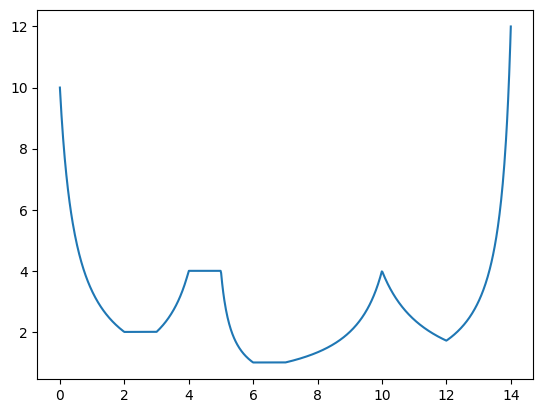

In [603]:
import matplotlib.pyplot as plt

xs = np.linspace(0, 840, 840)
ys = [INTERARRIVAL_FUNC(x, 2) for x in xs]

plt.plot(xs / 60, ys)